# LSTM을 활용한 전려소요 예측 모델

- TensorFlow Dataset 클래스를 활용하여 전력소요 데이터 구축
- LSTM 을 활용한 전력소요 예측 모델 구축

## 필요한 모듈 import

In [1]:
from matplotlib import font_manager, rc
import matplotlib, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import platform
import tensorflow as tf

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
plt.rcParams['axes.unicode_minus'] == False

False

## 데이터 (FinanceDataReader)

In [2]:
# 시간별_전력데이터 전체 (2012-06-01 ~ 2022-04-07)
path = '../processing_data/시간별_전력데이터.csv'
df_s = pd.read_csv(path, encoding='cp949')

In [3]:
path = '../data/한국전력거래소_지역별 시간별 태양광 발전량_20211231.csv'
# blackout_df = pd.read_excel(path1)
df_power = pd.read_csv(path, encoding='cp949')
# df_power.drop(columns = 'Unnamed: 0', inplace =True)

### 컬럼 설명

- `공급능력`:   전력생산량
- `현재수요`:   그날 사용한 전력량
- `공급예비력`:   전력 생산하고 남은 양
- `전력예비율`:  전력예비율 = (총 공급 전력량-최대 전력수요 / 최대 전력 수요) × 100
전력예비율이 6% 이하로 떨어지면 블랙아웃 가능성이 높아졌다는 뜻


In [4]:
df_power.tail()

,거래일자,거래시간,지역,발전량
596083,2021-12-31,20,충청북도,47668.337
596084,2021-12-31,21,충청북도,41720.571
596085,2021-12-31,22,충청북도,23464.794
596086,2021-12-31,23,충청북도,8098.187
596087,2021-12-31,24,충청북도,2451.798


## 시각화

In [5]:
# convert column B to timedelta object
df_power['거래시간'] = pd.to_timedelta(df_power['거래시간'], unit='H')
df_power['거래시간'] 
# add column B to column A
df_power['일시'] = pd.to_datetime(df_power['거래일자']) + df_power['거래시간']
df_power['일시']
# replace time in column A with updated time

# drop column B if no longer needed
df_power.drop(['거래일자', '거래시간'], axis=1, inplace=True)


In [6]:
df_power.set_index('일시',inplace=True)

df_power = df_power.between_time('8:00:00', '18:00:00')
df_power.reset_index(col_fill= '일시')
df_power.reset_index(col_fill= '일시',inplace=True)

In [7]:
df_power

,일시,지역,발전량
0,2018-01-01 08:00:00,강원도,113.859
1,2018-01-01 09:00:00,강원도,8704.912
2,2018-01-01 10:00:00,강원도,41926.638
3,2018-01-01 11:00:00,강원도,67930.358
4,2018-01-01 12:00:00,강원도,81280.313
...,...,...,...
273202,2021-12-31 14:00:00,충청북도,113775.537
273203,2021-12-31 15:00:00,충청북도,101522.028
273204,2021-12-31 16:00:00,충청북도,70747.386
273205,2021-12-31 17:00:00,충청북도,23120.171


In [8]:
df_power = df_power.groupby(['일시'], as_index=False)['발전량 '].sum()

전력소요 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['발전량 ']
# 스케일 후 columns|
scaled = scaler.fit_transform(df_power[scale_cols])
scaled

array([[0.00061598],
       [0.03974508],
       [0.15603147],
       ...,
       [0.3407304 ],
       [0.13310812],
       [0.17068488]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [10]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [11]:
df.shape

(16071, 1)

## train / test 분할

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train = df[:-3650]
test = df[-3650:]

In [14]:
test

,발전량
12421,0.444135
12422,0.478174
12423,0.578836
12424,0.624973
12425,0.685506
...,...
16066,0.562839
16067,0.504043
16068,0.340730
16069,0.133108


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

---



In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    # y.shape읙 값을 (y, ) -> (y,1)로 변경
    series = tf.expand_dims(series, axis=-1)
    #  series에서 TensorFlow 데이터세트를 생성합니다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [16]:
WINDOW_SIZE=3650
BATCH_SIZE=32

In [17]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 3650, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)


## 모델

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [20]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [21]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [22]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    275/Unknown - 378s 1s/step - loss: 0.0107 - mse: 0.0214WARNING:tensorflow:Can save best model only with val_loss available, skipping.
275/275 [==============================] - 380s 1s/step - loss: 0.0107 - mse: 0.0214
Epoch 2/50
275/275 [==============================] - 385s 1s/step - loss: 0.0038 - mse: 0.0077
Epoch 3/50
275/275 [==============================] - 390s 1s/step - loss: 0.0023 - mse: 0.0046
Epoch 4/50
275/275 [==============================] - 399s 1s/step - loss: 0.0020 - mse: 0.0040
Epoch 5/50
275/275 [==============================] - 385s 1s/step - loss: 0.0018 - mse: 0.0037
Epoch 6/50
275/275 [==============================] - 384s 1s/step - loss: 0.0018 - mse: 0.0035
Epoch 7/50
275/275 [==============================] - 393s 1s/step - loss: 0.0017 - mse: 0.0033
Epoch 8/50
275/275 [==============================] - 369s 1s/step - loss: 0.0016 - mse: 0.0032
Epoch 9/50
275/275 [==============================] - 370s 1s/step - loss: 0.0015 - mse: 0.003

저장한 ModelCheckpoint 를 로드합니다.

In [23]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [28]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>

In [27]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>

In [26]:
pred = model.predict(test_data)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
pred.shape

(3285, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

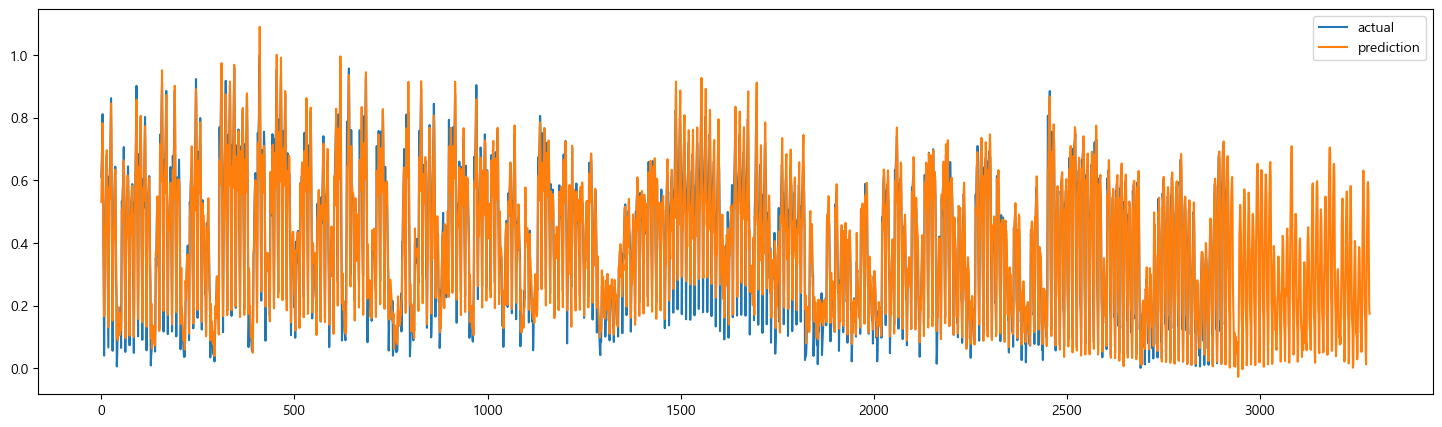

In [ ]:
fig = plt.figure(figsize=(18, 5)) 
plt.plot(np.asarray(test[:-365])[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

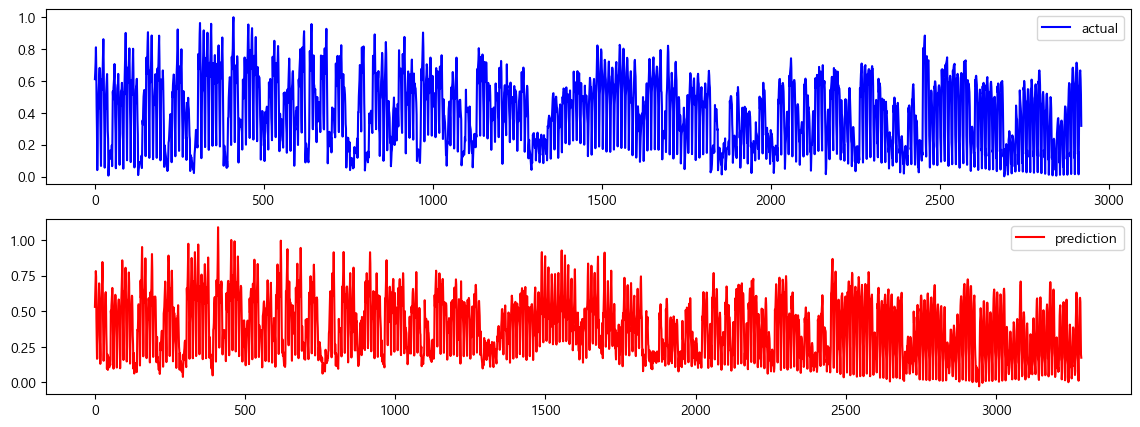

In [ ]:
fig = plt.figure(figsize=(14, 5)) # 그림 사이즈 지정 (가로 14인치, 세로 5인치)
ax1 = fig.add_subplot(2, 1, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(2, 1, 2) # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

ax1.plot(np.asarray(test[:-365])[WINDOW_SIZE:], label='actual', color='blue')
ax1.legend()
ax2.plot(pred, label='prediction', color='red')
ax2.legend()
plt.show()


In [ ]:
pred.shape

(3285, 1)

In [ ]:
y_test[365:]

12786    0.611467
12787    0.654716
12788    0.714799
12789    0.811230
12790    0.678842
           ...   
16066    0.562839
16067    0.504043
16068    0.340730
16069    0.133108
16070    0.170685
Name: 발전량 , Length: 3285, dtype: float64

In [ ]:
type(pred)

numpy.ndarray

In [ ]:
pred

array([[0.5308042 ],
       [0.62723476],
       [0.6924718 ],
       ...,
       [0.36282402],
       [0.19688699],
       [0.17383957]], dtype=float32)

In [ ]:
def smape(true, pred):
    v = abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output
print(smape(test[:-365],pred))

발전량     31.211639
dtype: float64


c:\Users\ban05\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
preds = pred.flatten()
margin_of_error = preds - test[:-365]

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error /y_test[:-365]).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

ValueError: Unable to coerce to Series, length must be 1: given 3285

In [ ]:
import numpy as np

# Create a sample dataset
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# Normalize the data using min-max normalization
min_val = np.min(data)
max_val = np.max(data)
data_norm = (data - min_val) / (max_val - min_val)

# Revert the normalized data
data_reverted = (preds * (max_val - min_val)) + min_val

print("Original data:", data)
print("Normalized data:", data_norm)
print("Reverted data:", data_reverted)


Original data: 0        64355.00000
1        64355.00000
2        64559.16667
3        64845.00000
4        64845.00000
            ...     
77573    77170.92500
77574    77757.55000
77575    78301.11667
77576    77992.78333
77577    77427.35833
Name: 공급능력(MW), Length: 77578, dtype: float64
Normalized data: 0        0.049615
1        0.049615
2        0.053143
3        0.058082
4        0.058082
           ...   
77573    0.271091
77574    0.281228
77575    0.290622
77576    0.285293
77577    0.275522
Name: 공급능력(MW), Length: 77578, dtype: float64
Reverted data: [ 92199.516  97779.56  101554.58  ...  82479.17   72877.06   71543.4  ]


In [ ]:
import numpy as np

# 샘플 데이터 생성
data = np.array([1, 2, 3, 4, 5])
data = df_s['공급능력(MW)'].iloc[:-8760]
# 최소-최대 정규화를 사용하여 데이터 정규화
min_val = np.min(data)
max_val = np.max(data)
# data_norm = (data - min_val) / (max_val - min_val)

# 정규화된 데이터를 되돌리기
data_reverted_Y = (y_test[:-365] * (max_val - min_val)) + min_val

print("원본 데이터:", data)
print("정규화된 데이터:", data_norm)
print("되돌린 데이터:", data_reverted)


원본 데이터: 0        64355.00000
1        64355.00000
2        64559.16667
3        64845.00000
4        64845.00000
            ...     
77573    77170.92500
77574    77757.55000
77575    78301.11667
77576    77992.78333
77577    77427.35833
Name: 공급능력(MW), Length: 77578, dtype: float64
정규화된 데이터: 0        0.049615
1        0.049615
2        0.053143
3        0.058082
4        0.058082
           ...   
77573    0.271091
77574    0.281228
77575    0.290622
77576    0.285293
77577    0.275522
Name: 공급능력(MW), Length: 77578, dtype: float64
되돌린 데이터: [ 92199.516  97779.56  101554.58  ...  82479.17   72877.06   71543.4  ]


In [ ]:
data_reverted

array([ 92199.516,  97779.56 , 101554.58 , ...,  82479.17 ,  72877.06 ,
        71543.4  ], dtype=float32)

In [ ]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
preds = pred.flatten()
margin_of_error = data_reverted - data_reverted_Y

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error /y_test[:-365]).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Margin of error: 12421     5015.198177
12422     8625.563200
12423     6575.650779
12424     9099.740139
12425     3308.833019
             ...     
15701    -3497.852007
15702    -5823.221961
15703   -14306.481790
15704   -18412.211893
15705    -8353.483782
Name: 발전량 , Length: 3285, dtype: float64
MAE: -356.0236193450933
MPE: 6773984.237758978
MSE: 243716763.33690077
RMSE: 15611.430534608313


In [ ]:
data_reverted_Y

77578     80686.676409
77579     82266.821866
77580     83749.137505
77581     85511.143201
77582     87871.441974
             ...      
85968     87959.999777
85969     89483.800531
85970     92173.051880
85971     96498.680404
85972    102679.677896
Name: 현재수요(MW), Length: 8395, dtype: float64

In [ ]:
data_reverted

array([93641.4 , 92464.65, 91695.41, ..., 91718.34, 90133.38, 89208.08],
      dtype=float32)